In this experiment you will generate traffic using MoonGen and capture it with DAG.  
###### Setup:  

-- `bash /root/<crsid>/L50/setup/moon_setup.sh` (Machine B)  
-- `ssh-add` (Machine A)   
-- `dagload`  (Machine A)   
-- `ifconfig slf0 up` (Machine A)  
-- Connect intl0 (B) to dag0 (A).     
-- Connect intl1 (B) to slf0 (A).        
<img src="alt_setup3.3.jpg">

MoonGen takes a script as an argument, which specifies how packets are to be sent. Here is the <a href="https://www.net.in.tum.de/fileadmin/TUM/NET/NET-2016-07-1/NET-2016-07-1_06.pdf">tutorial</a> on writing custom scripts. There is a prepared script L50/Jupyter/useful/generator.lua to use for this experiment. 
  
###### Usage:   
`moongen/build/MoonGen  L50/Jupyter/useful/generator.lua  <number of ports>  <rate (Mbits/sec)>  <iterations>  <packet size (bytes)>`  
NB. Each iteration is 100 packets. You can change this in generator.lua.   
NB. To send as fast as possible, set rate as 10000.   
NB. You can send on 1 or 2 ports.  

Eg. Send 500,000 512B packets at rate 10 Mbits/sec on 1 port.  
`moongen/build/MoonGen L50/Jupyter/useful/generator.lua 1 10 5000 512`  

In [5]:
crsid='jlf60'
%run /root/$crsid/L50/Jupyter/useful/useful.py
%run /root/$crsid/L50/Jupyter/useful/useful3.py
%matplotlib inline
machB_ip = '128.232.82.64' # REPLACE THIS

The function `send` will be used throughout this Notebook:  
Generate traffic from the NIC (Machine B) using MoonGen. Traffic to the DAG card (Machine A) is captured to a .erf file. One summary line for each packet received is written to a .txt file. Check that these are correctly saved to L50Lab3/3.3.  


In [6]:
def send(exp,num,size,rate=10000,ports=1):
    # num = no of packets to send
    # size = packet size in bytes
    # rate = sending rate in Mbits/sec
    # ports = how many ports to send to
    
    dag_cmd = shlex.split('dagsnap -d0 -o /root/'+crsid+'/L50Lab3/3.3/'+exp+'.erf')
    p = Popen(dag_cmd) # start capture
    sleep(2)
    play_cmd = ('/root/MoonGen/build/MoonGen /root/'+crsid+'/L50/Jupyter/useful/generator.lua '
                +str(ports)+' '+str(rate)+' '+str(num/100)+' '+str(size))
    ssh = ssh_connect(machB_ip)
    ssh_cmd(play_cmd, ssh) # generate traffic
    sleep(2)
    ssh.close()
    p.kill() # end capture
    sleep(2)
    local_cmd('tshark -r /root/'+crsid+'/L50Lab3/3.3/'+exp+'.erf > /root/'+crsid+'/L50Lab3/3.3/'+exp+'.txt') # write summary lines

## Experiment a

Send 1000 packets, size 512B. See that all the packets arrive.

In [3]:
send('exp3a',1000, 512)

In [4]:
num_pkts = sum(1 for line in open('/root/'+crsid+'/L50Lab3/3.3/exp3a.txt') if line)
print "Packets received: " + str(num_pkts)

Packets received: 1000


## Experiment b

Send 100000 packets, size 512B. See that all the packets arrive. What is the captured packet rate?

In [5]:
send('exp3b',100000, 512)

In [6]:
num_pkts = sum(1 for line in open('/root/'+crsid+'/L50Lab3/3.3/exp3b.txt') if line)
print "Packets received: " + str(num_pkts)

deltas = getdeltas('3.3/exp3b',crsid,10000)
pps = int(floor(1.0 / np.median(deltas) * 1000000))
print "Packets per second: " + str(pps)

Packets received: 100000
Packets per second: 2331002


## Experiment c

Send 10000 packets, size 1024B / 512B / 64B. What is the maximum packet rate supported by the tool? what is the maximal bandwidth? What is the effect of line coding (64b/66b)?

In [7]:
def rate(exp,size,num):
    deltas = getdeltas(exp,crsid,num)
    rt = (size+20+4)*8/ np.average(deltas)
    pps = int(floor(1.0 / np.median(deltas) * 1000000))
    print "Packets per second: " + str(pps)
    print "Rate: " + str(rt) + " Mbits/sec" 

### 1024B

In [8]:
send('exp3c1',10000,1024)

In [9]:
rate('3.3/exp3c1',1024,10000)

Packets per second: 1190476
Rate: 9999.820595964937 Mbits/sec


### 512B

In [10]:
send('exp3c2',10000,512)

In [11]:
rate('3.3/exp3c2',512,10000)

Packets per second: 2336448
Rate: 9999.811551870345 Mbits/sec


### 64B

In [12]:
send('exp3c3',10000,64)

In [13]:
rate('3.3/exp3c3',64,10000)

Packets per second: 13888888
Rate: 4206.824342737483 Mbits/sec


## Experiment d

Send 10000 packets, size 512B, 100 Mbits/sec. What is the measured traffic rate?

In [14]:
send('exp3d',10000,512,100)

rate('3.3/exp3d',512,10000)

## Experiment e

What is the distribution of inter-arrival time of experiment d?

Plot the CDF of inter-arrival time.

Mean: 41.2438839884
Median: 0.432
Variance: 1669.04126967


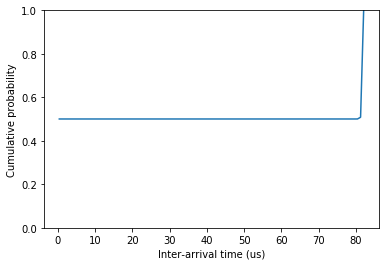

In [7]:
import statistics
deltas = getdeltas('3.3/exp3d', crsid,10000)
print("Mean: " + str(statistics.mean(deltas)))
print("Median: " + str(statistics.median(deltas)))
print("Variance: " + str(statistics.variance(deltas)))
values, base = np.histogram(deltas, bins=100)
cumulative = np.cumsum(values/9999.0)
plt.plot(base[:-1], cumulative)
plt.ylabel("Cumulative probability")
plt.xlabel("Inter-arrival time (us)")
ax = plt.gca()
ax.set_ylim([.0, 1.])
plt.show()

## Experiment f

Send 10000 packets, size 512B, intl0 (B) to dag0 (A), intl1  (B) to slf0  (B), 100 Mbits/sec. What is the distribution of inter-arrival time?

In [17]:
send('exp3f',10000,512,100,2)

Plot the CDF of inter-arrival time.

Mean: 41.2438823882
Median: 0.433
Variance: 1669.04288275


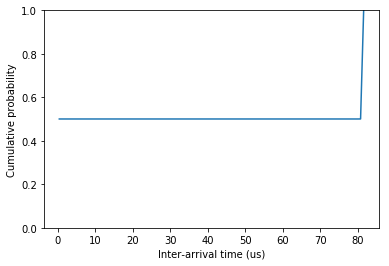

In [8]:
deltas = getdeltas('3.3/exp3f',crsid, 10000)
print("Mean: " + str(statistics.mean(deltas)))
print("Median: " + str(statistics.median(deltas)))
print("Variance: " + str(statistics.variance(deltas)))
values, base = np.histogram(deltas, bins=100)
cumulative = np.cumsum(values/9999.0)
plt.plot(base[:-1], cumulative)
plt.ylabel("Cumulative probability")
plt.xlabel("Inter-arrival time (us)")
ax = plt.gca()
ax.set_ylim([.0, 1.])
plt.show()

CDF shows 50% packets arrive at scale of 0.00000042 seconds and the other at 0.000082 seconds, alternating between the two. This is because Moongen operates on packets and cannot set time intervals, so instead sends dummy packets in order to produce the requested rate. This means that 2 packets are sent in quick succession then large downtime of dummy packets, this is repeated to get the requested average send rate.